#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Обсудите постановку задачи сегментации изображений.

2\. Рассмотрите пример работы слоя `ConvTranspose2d`.

## Задачи для самостоятельного решения

In [ ]:
from pathlib import Path
import zipfile

In [ ]:
BASE_PATH = Path("/content")
ZIP_PATH = BASE_PATH / "archive.zip"
EXTRACT_ROOT = BASE_PATH / "clothes_extracted"

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_ROOT)

print("Распаковано в:", EXTRACT_ROOT)
for p in EXTRACT_ROOT.iterdir():
    print(" -", p)

Распаковано в: /content/clothes_extracted
 - /content/clothes_extracted/Test
 - /content/clothes_extracted/Train


<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import numpy as np
from torchvision import transforms

In [ ]:
ROOT_CLOTHES = EXTRACT_ROOT

In [ ]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, root, split="Train",
                 img_transform=None,
                 mask_transform=None):
        self.root = Path(root)
        self.split = split
        self.img_dir = self.root / split / "Image"
        self.mask_dir = self.root / split / "Mask"

        self.img_transform = img_transform
        self.mask_transform = mask_transform

        img_ids = {p.stem for p in self.img_dir.glob("*.jpg")}
        mask_ids = {p.stem.replace(".jpg", "") for p in self.mask_dir.glob("*.png")}
        self.ids = sorted(img_ids & mask_ids)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = self.img_dir / f"{img_id}.jpg"
        mask_path = self.mask_dir / f"{img_id}.jpg.png"

        image = Image.open(img_path).convert("RGB")

        mask_rgba = Image.open(mask_path).convert("RGBA")
        mask_np = np.array(mask_rgba)
        mask_np = mask_np[:, :, 0]
        mask_img = Image.fromarray(mask_np.astype("uint8"))

        if self.img_transform is not None:
            image_t = self.img_transform(image)
        else:
            image_t = transforms.ToTensor()(image)

        if self.mask_transform is not None:
            mask_t = self.mask_transform(mask_img)
        else:
            mask_t = torch.from_numpy(mask_np)[None, ...]

        mask_t = mask_t.long()

        return image_t, mask_t

In [ ]:
train_dataset_raw = ClothesSegmentationDataset(ROOT_CLOTHES, split="Train")

img, mask = train_dataset_raw[0]
print("image shape:", img.shape, "dtype:", img.dtype)
print("mask shape:", mask.shape, "dtype:", mask.dtype)
print("min class id:", mask.min().item(), "max class id:", mask.max().item())

image shape: torch.Size([3, 1440, 1080]) dtype: torch.float32
mask shape: torch.Size([1, 1440, 1920]) dtype: torch.int64
min class id: 0 max class id: 255


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def show_image_with_mask(image, mask):
    if isinstance(image, torch.Tensor):
        img_np = image.detach().cpu().numpy()
        if img_np.ndim == 3 and img_np.shape[0] == 3:
            img_np = np.transpose(img_np, (1, 2, 0))
    else:
        img_np = np.array(image)

    if isinstance(mask, torch.Tensor):
        mask_np = mask.detach().cpu().numpy()
    else:
        mask_np = np.array(mask)

    if mask_np.ndim == 3:
        mask_np = mask_np[0]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    im = axes[1].imshow(mask_np, cmap="jet")
    axes[1].set_title("Mask (class ids)")
    axes[1].axis("off")
    fig.colorbar(im, ax=axes[1])
    plt.show()

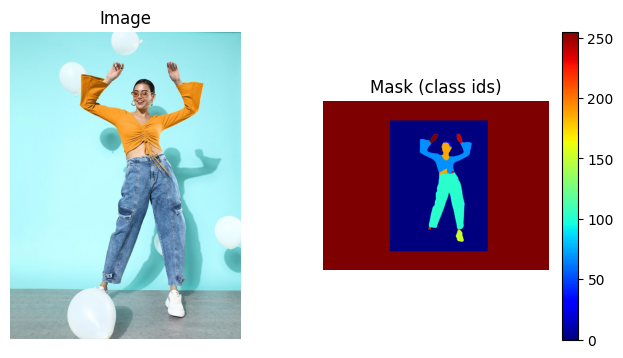

In [ ]:
img, mask = train_dataset_raw[0]
show_image_with_mask(img, mask)

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [ ]:
from torchvision import transforms
from PIL import Image

In [ ]:
IMAGE_SIZE = (256, 256)

img_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
mask_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: t.long()),
])

In [ ]:
train_dataset = ClothesSegmentationDataset(
    ROOT_CLOTHES,
    split="Train",
    img_transform=img_transform,
    mask_transform=mask_transform,
)

In [ ]:
import torch

In [ ]:
def get_num_classes(dataset):
    max_id = 0
    for _, m in dataset:
        max_id = max(max_id, int(m.max()))
    return max_id + 1

n_classes = get_num_classes(train_dataset)
print("n_classes:", n_classes)

n_classes: 256


In [ ]:
import torch.nn as nn
import torch

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_unet = UNet(n_channels=3, n_classes=n_classes).to(device)

In [ ]:
x, y = train_dataset[0]
x = x.unsqueeze(0).to(device)
with torch.no_grad():
    out = model_unet(x)

print("UNet output shape:", out.shape)

UNet output shape: torch.Size([1, 256, 256, 256])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import random_split, DataLoader

In [ ]:
full_dataset = train_dataset

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

print("Train size:", len(train_ds), "Val size:", len(val_ds))

Train size: 153 Val size: 39


In [ ]:
import torch

In [ ]:
def compute_class_weights(dataset, num_classes):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for _, mask in dataset:
        m = mask.view(-1)
        bincount = torch.bincount(m, minlength=num_classes)
        counts += bincount
    freq = counts.float() / counts.sum()
    weights = 1.0 / (freq + 1e-6)
    weights = weights / weights.sum() * num_classes
    return weights

In [ ]:
class_weights = compute_class_weights(train_ds, n_classes).to(device)
print("class_weights shape:", class_weights.shape)

class_weights shape: torch.Size([256])


In [ ]:
import torch.nn as nn

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)

In [ ]:
def pixel_accuracy(logits, masks):
    preds = torch.argmax(logits, dim=1)
    if masks.ndim == 4:
        masks = masks[:,0]
    correct = (preds == masks).float().mean()
    return correct

In [ ]:
from tqdm.auto import tqdm
import time

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model_unet.train()
    train_loss = 0.0
    train_acc = 0.0

    train_pbar = tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", leave=False)

    start_time = time.time()

    for images, masks in train_pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model_unet(images)

        loss = criterion(logits, masks[:, 0])
        acc = pixel_accuracy(logits, masks)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)

        train_loss += loss.item() * batch_size
        train_acc += acc.item() * batch_size

        train_pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc.item():.4f}"
        })

    epoch_time = time.time() - start_time

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    model_unet.eval()
    val_loss = 0.0
    val_acc = 0.0

    val_pbar = tqdm(val_loader, desc=f"Val {epoch+1}/{num_epochs}", leave=False)

    with torch.no_grad():
        for images, masks in val_pbar:
            images = images.to(device)
            masks = masks.to(device)

            logits = model_unet(images)

            loss = criterion(logits, masks[:, 0])
            acc = pixel_accuracy(logits, masks)

            batch_size = images.size(0)

            val_loss += loss.item() * batch_size
            val_acc += acc.item() * batch_size

            val_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc.item():.4f}"
            })

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | "
          f"time={epoch_time:.1f}s")


Epoch 1/20


Train 1/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 1/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 | train_loss=5.6110, train_acc=0.0014 | val_loss=5.5633, val_acc=0.0010 | time=27.2s

Epoch 2/20


Train 2/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 2/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 | train_loss=5.5384, train_acc=0.0022 | val_loss=5.5626, val_acc=0.0022 | time=20.2s

Epoch 3/20


Train 3/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 3/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 | train_loss=5.4998, train_acc=0.0056 | val_loss=5.5593, val_acc=0.0049 | time=20.0s

Epoch 4/20


Train 4/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 4/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 | train_loss=5.4646, train_acc=0.0149 | val_loss=5.5523, val_acc=0.0183 | time=20.8s

Epoch 5/20


Train 5/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 5/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 | train_loss=5.4274, train_acc=0.0334 | val_loss=5.5583, val_acc=0.0276 | time=20.3s

Epoch 6/20


Train 6/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 6/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 | train_loss=5.3712, train_acc=0.0544 | val_loss=5.5596, val_acc=0.0727 | time=20.6s

Epoch 7/20


Train 7/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 7/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 | train_loss=5.3206, train_acc=0.0739 | val_loss=5.5542, val_acc=0.0371 | time=20.4s

Epoch 8/20


Train 8/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 8/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 | train_loss=5.2221, train_acc=0.0681 | val_loss=5.5660, val_acc=0.0363 | time=20.3s

Epoch 9/20


Train 9/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 9/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 | train_loss=5.1113, train_acc=0.0220 | val_loss=5.6781, val_acc=0.0166 | time=20.5s

Epoch 10/20


Train 10/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 10/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 | train_loss=5.0185, train_acc=0.0150 | val_loss=5.5832, val_acc=0.0028 | time=20.4s

Epoch 11/20


Train 11/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 11/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 | train_loss=4.8558, train_acc=0.0080 | val_loss=5.6199, val_acc=0.0024 | time=20.2s

Epoch 12/20


Train 12/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 12/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 | train_loss=4.7180, train_acc=0.0054 | val_loss=5.7144, val_acc=0.0019 | time=20.4s

Epoch 13/20


Train 13/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 13/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 | train_loss=4.5481, train_acc=0.0027 | val_loss=5.6251, val_acc=0.0013 | time=20.3s

Epoch 14/20


Train 14/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 14/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 | train_loss=4.3743, train_acc=0.0023 | val_loss=5.7683, val_acc=0.0012 | time=20.4s

Epoch 15/20


Train 15/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 15/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 | train_loss=4.1584, train_acc=0.0024 | val_loss=5.7222, val_acc=0.0014 | time=20.6s

Epoch 16/20


Train 16/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 16/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 | train_loss=3.9006, train_acc=0.0022 | val_loss=5.7243, val_acc=0.0008 | time=20.4s

Epoch 17/20


Train 17/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 17/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 | train_loss=3.7367, train_acc=0.0020 | val_loss=5.6879, val_acc=0.0005 | time=20.5s

Epoch 18/20


Train 18/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 18/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 | train_loss=3.4927, train_acc=0.0024 | val_loss=5.8921, val_acc=0.0006 | time=20.3s

Epoch 19/20


Train 19/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 19/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 | train_loss=3.2650, train_acc=0.0022 | val_loss=5.7822, val_acc=0.0006 | time=20.6s

Epoch 20/20


Train 20/20:   0%|          | 0/39 [00:00<?, ?it/s]

Val 20/20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 | train_loss=3.0720, train_acc=0.0024 | val_loss=5.8100, val_acc=0.0012 | time=20.5s


In [ ]:
def show_unet_prediction(dataset, idx):
    model_unet.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        logits = model_unet(image.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1)[0].cpu()

    img_denorm = image.clone()
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img_denorm = img_denorm * std + mean
    img_np = img_denorm.permute(1,2,0).cpu().numpy().clip(0,1)

    mask_np = mask[0].cpu().numpy()
    pred_np = pred.cpu().numpy()

    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(img_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="jet")
    axes[1].set_title("GT mask")
    axes[1].axis("off")

    axes[2].imshow(pred_np, cmap="jet")
    axes[2].set_title("Pred mask")
    axes[2].axis("off")

    plt.show()

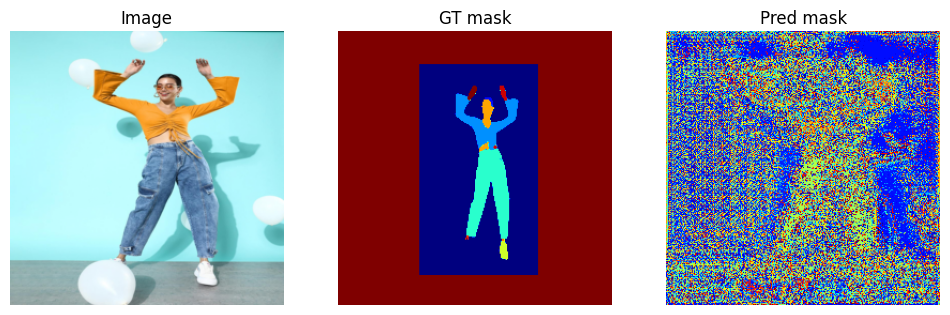

In [ ]:
show_unet_prediction(full_dataset, 0)

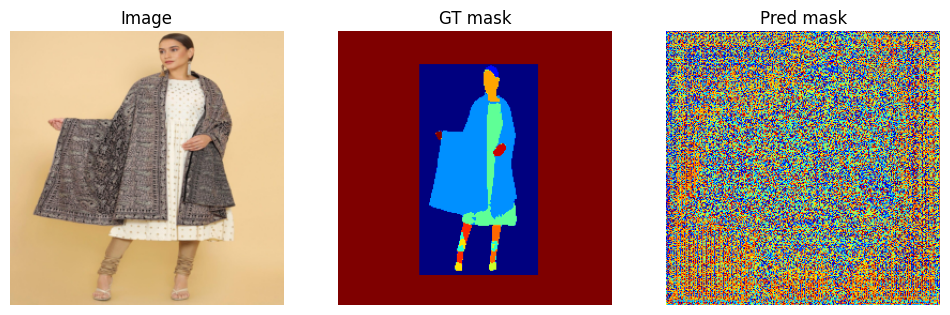

In [ ]:
show_unet_prediction(full_dataset, 1)

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import SegformerForSemanticSegmentation

In [ ]:
segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=n_classes,
    ignore_mismatched_sizes=True,
).to(device)

optimizer_sf = torch.optim.AdamW(segformer.parameters(), lr=5e-5)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([256]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([256, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn.functional as F

def segformer_pixel_accuracy(logits, masks):
    if masks.ndim == 4:
        masks = masks[:, 0]

    logits_up = F.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False,
    )

    preds = torch.argmax(logits_up, dim=1)

    acc = (preds == masks).float().mean()
    return acc

In [ ]:
num_epochs_sf = 15

for epoch in range(num_epochs_sf):
    print(f"Epoch {epoch+1}/{num_epochs_sf}")

    segformer.train()
    train_loss = 0.0
    train_acc = 0.0

    train_pbar = tqdm(train_loader,
                      desc=f"Train {epoch+1}/{num_epochs_sf}",
                      leave=False)

    start_time = time.time()

    for images, masks in train_pbar:
        images = images.to(device)
        masks  = masks.to(device)

        optimizer_sf.zero_grad()
        outputs = segformer(pixel_values=images, labels=masks[:, 0])

        loss = outputs.loss
        logits = outputs.logits

        acc = segformer_pixel_accuracy(logits, masks)

        loss.backward()
        optimizer_sf.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        train_acc  += acc.item() * batch_size

        train_pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc.item():.4f}"
        })

    epoch_time = time.time() - start_time

    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)

    segformer.eval()
    val_loss = 0.0
    val_acc = 0.0

    val_pbar = tqdm(val_loader,
                    desc=f"Val {epoch+1}/{num_epochs_sf}",
                    leave=False)

    with torch.no_grad():
        for images, masks in val_pbar:
            images = images.to(device)
            masks  = masks.to(device)

            outputs = segformer(pixel_values=images, labels=masks[:, 0])
            loss = outputs.loss
            logits = outputs.logits

            acc = segformer_pixel_accuracy(logits, masks)

            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            val_acc  += acc.item() * batch_size

            val_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc.item():.4f}"
            })

    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs_sf} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | "
          f"time={epoch_time:.1f}s")


Epoch 1/15


Train 1/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 1/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/15 | train_loss=4.9686, train_acc=0.1225 | val_loss=4.4896, val_acc=0.1780 | time=29.0s
Epoch 2/15


Train 2/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 2/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/15 | train_loss=4.0481, train_acc=0.1888 | val_loss=3.4852, val_acc=0.1949 | time=14.4s
Epoch 3/15


Train 3/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 3/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/15 | train_loss=3.1052, train_acc=0.2004 | val_loss=2.5180, val_acc=0.2045 | time=14.4s
Epoch 4/15


Train 4/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 4/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/15 | train_loss=2.3512, train_acc=0.2130 | val_loss=2.1674, val_acc=0.2153 | time=14.5s
Epoch 5/15


Train 5/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 5/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/15 | train_loss=1.9754, train_acc=0.2190 | val_loss=1.8647, val_acc=0.2206 | time=14.4s
Epoch 6/15


Train 6/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 6/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/15 | train_loss=1.7487, train_acc=0.2231 | val_loss=1.7055, val_acc=0.2205 | time=18.5s
Epoch 7/15


Train 7/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 7/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/15 | train_loss=1.5956, train_acc=0.2256 | val_loss=1.6181, val_acc=0.2223 | time=14.9s
Epoch 8/15


Train 8/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 8/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/15 | train_loss=1.4951, train_acc=0.2282 | val_loss=1.5633, val_acc=0.2237 | time=14.4s
Epoch 9/15


Train 9/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 9/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/15 | train_loss=1.4371, train_acc=0.2302 | val_loss=1.4881, val_acc=0.2242 | time=14.9s
Epoch 10/15


Train 10/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 10/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/15 | train_loss=1.3528, train_acc=0.2324 | val_loss=1.4421, val_acc=0.2246 | time=14.5s
Epoch 11/15


Train 11/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 11/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/15 | train_loss=1.3033, train_acc=0.2365 | val_loss=1.3968, val_acc=0.2269 | time=14.8s
Epoch 12/15


Train 12/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 12/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/15 | train_loss=1.2359, train_acc=0.2379 | val_loss=1.3886, val_acc=0.2260 | time=14.4s
Epoch 13/15


Train 13/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 13/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/15 | train_loss=1.2082, train_acc=0.2402 | val_loss=1.3447, val_acc=0.2306 | time=14.7s
Epoch 14/15


Train 14/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 14/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/15 | train_loss=1.1622, train_acc=0.2418 | val_loss=1.3590, val_acc=0.2259 | time=14.3s
Epoch 15/15


Train 15/15:   0%|          | 0/39 [00:00<?, ?it/s]

Val 15/15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/15 | train_loss=1.1234, train_acc=0.2430 | val_loss=1.3230, val_acc=0.2274 | time=14.5s


In [ ]:
def show_segformer_prediction(dataset, idx):
    segformer.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        outputs = segformer(pixel_values=image.unsqueeze(0).to(device))
        logits = outputs.logits

        import torch.nn.functional as F
        logits_up = F.interpolate(
            logits,
            size=mask.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )
        pred = torch.argmax(logits_up, dim=1)[0].cpu()

    img_denorm = image.clone()
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img_denorm = img_denorm * std + mean
    img_np = img_denorm.permute(1,2,0).cpu().numpy().clip(0,1)

    mask_np = mask[0].cpu().numpy()
    pred_np = pred.numpy()

    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(img_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="jet")
    axes[1].set_title("GT mask")
    axes[1].axis("off")

    axes[2].imshow(pred_np, cmap="jet")
    axes[2].set_title("SegFormer Pred")
    axes[2].axis("off")
    plt.show()

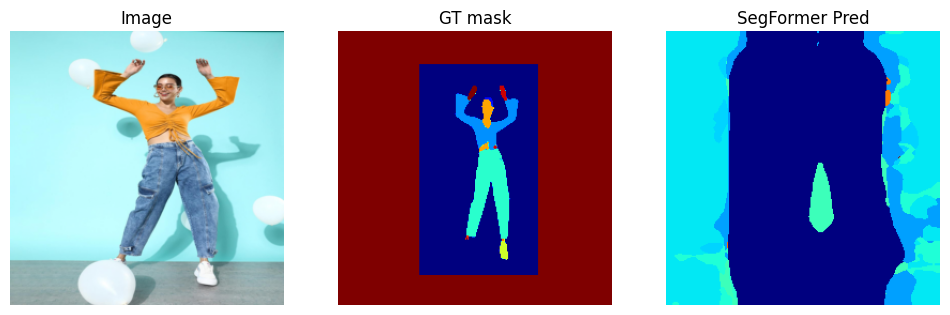

In [ ]:
show_segformer_prediction(full_dataset, 0)

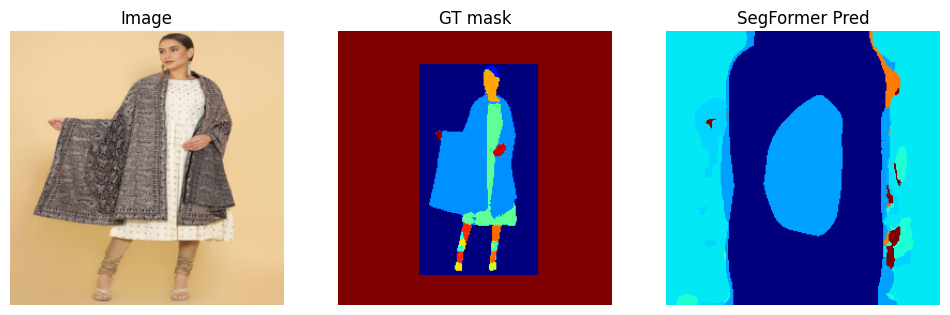

In [ ]:
show_segformer_prediction(full_dataset, 1)